In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [14]:
def window(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Power")
    plt.grid(True)

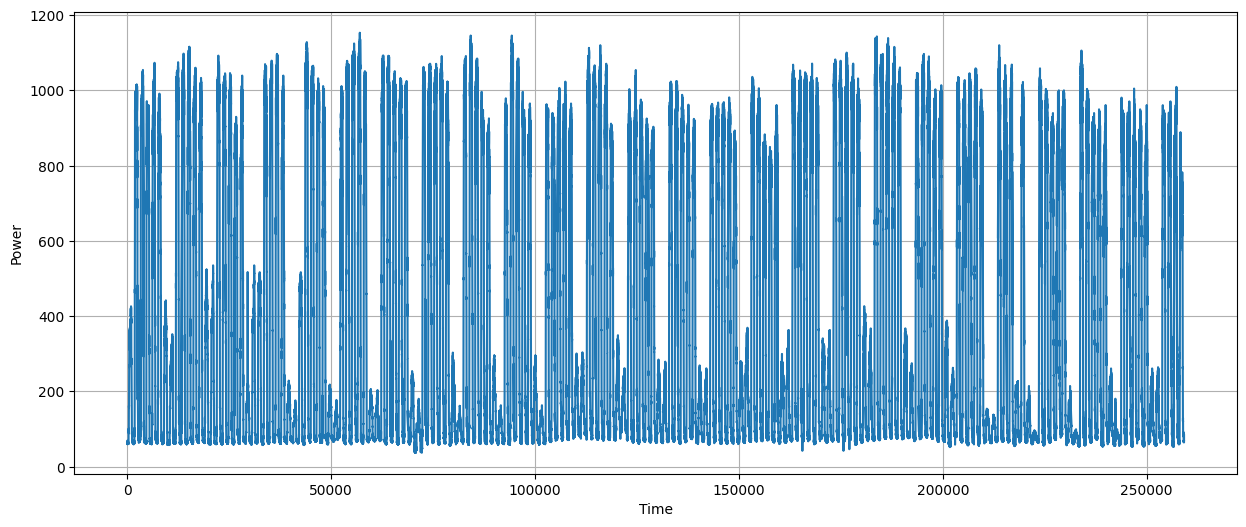

In [15]:
time_step = []
power = []

with open("/kaggle/input/powercon/Final Processed Data with MV(Total).csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step = 0
    for row in reader:
        power.append(float(row[2]))
        time_step.append(int(step))
        step += 1

series = np.array(power)
time = np.array(time_step)
plt.figure(figsize=(15, 6))
plot_series(time, series)

0.0 0.9678393005828477


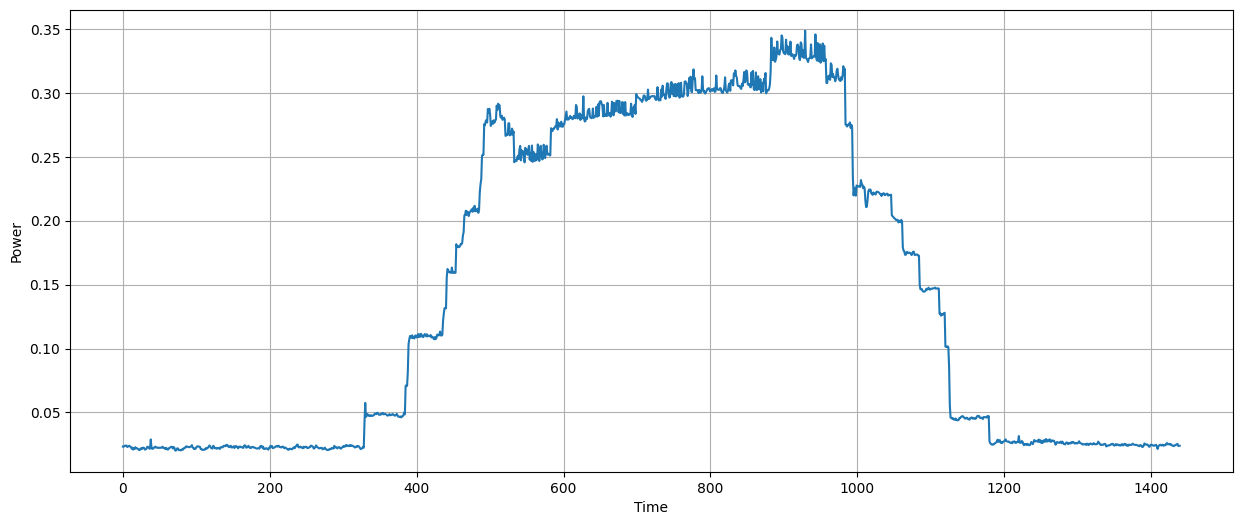

In [19]:
# Normalization
# scaler = MinMaxScaler()
# series = scaler.fit_transform(series_ori.reshape(-1, 1))

# min_vals = scaler.min_
# scale_vals = scaler.scale_

min_val=np.min(series)
max_val=np.max(series)
print(min_val, max_val)

series -= min_val
series /= max_val
time=np.array(time_step)

plt.figure(figsize=(15, 6))
plot_series(time, series, start=0, end=1440)

In [53]:
# Save scaler parameters
# np.savez('scaler_parameters.npz', min_vals=min_vals, scale_vals=scale_vals)

In [21]:
# Splot dataset (80/10/10)
x_train, x_val, x_test = series[:199296], series[199296:224208], series[224208:]
t_train, t_val, t_test = time_step[:199296], time_step[199296:224208], time_step[224208:]

window_size = 864
batch_size = 128
shuffle_buffer_size = 1024

In [22]:
train_dataset = window(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = window(x_val, window_size, batch_size, shuffle_buffer_size)
test_dataset = window(x_test, window_size, batch_size, shuffle_buffer_size)

In [23]:
# Train gru model
tf.keras.backend.clear_session()
model_gru = Sequential([
    tf.keras.layers.InputLayer([None, 1]),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 64)          12864     
                                                                 
 gru_1 (GRU)                 (None, None, 64)          24960     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 47,505
Trainable params: 47,505
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_gru.compile(
        optimizer=Adam(),
        loss=Huber(),
        metrics=["mae"]
    )

early_stop = EarlyStopping(monitor = 'val_mae', patience = 3, restore_best_weights=True)

history = model_gru.fit(
                    train_dataset,
                    validation_data=val_dataset,
                    batch_size=32,
                    epochs=100,
                    callbacks=[early_stop]
    )

Epoch 1/100
1551/1551 [==============================] - 267s 168ms/step - loss: 0.0547 - mae: 0.2849 - val_loss: 0.0335 - val_mae: 0.2165
Epoch 2/100
1551/1551 [==============================] - 252s 162ms/step - loss: 0.0376 - mae: 0.2176 - val_loss: 0.0303 - val_mae: 0.1781
Epoch 3/100
1551/1551 [==============================] - 254s 163ms/step - loss: 0.0374 - mae: 0.2162 - val_loss: 0.0303 - val_mae: 0.1782
Epoch 4/100
1551/1551 [==============================] - 272s 175ms/step - loss: 0.0374 - mae: 0.2162 - val_loss: 0.0303 - val_mae: 0.1780
Epoch 5/100
1551/1551 [==============================] - 282s 181ms/step - loss: 0.0374 - mae: 0.2162 - val_loss: 0.0303 - val_mae: 0.1777
Epoch 6/100
1551/1551 [==============================] - 271s 174ms/step - loss: 0.0374 - mae: 0.2162 - val_loss: 0.0303 - val_mae: 0.1780
Epoch 7/100
1551/1551 [==============================] - 255s 164ms/step - loss: 0.0374 - mae: 0.2162 - val_loss: 0.0303 - val_mae: 0.1780
Epoch 8/100
1551/1551 [====

In [25]:
import pickle

# Assuming 'model' is your trained machine learning model
# Save the model to a file using pickle
with open('gru_model.pkl', 'wb') as file:
    pickle.dump(model_gru, file)

In [26]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [27]:
rnn_forecast = model_forecast(model_gru, series[..., np.newaxis], window_size)

8073/8073 [==============================] - 299s 37ms/step


In [11]:
rnn_forecast_test = rnn_forecast[224208-window_size:-1]

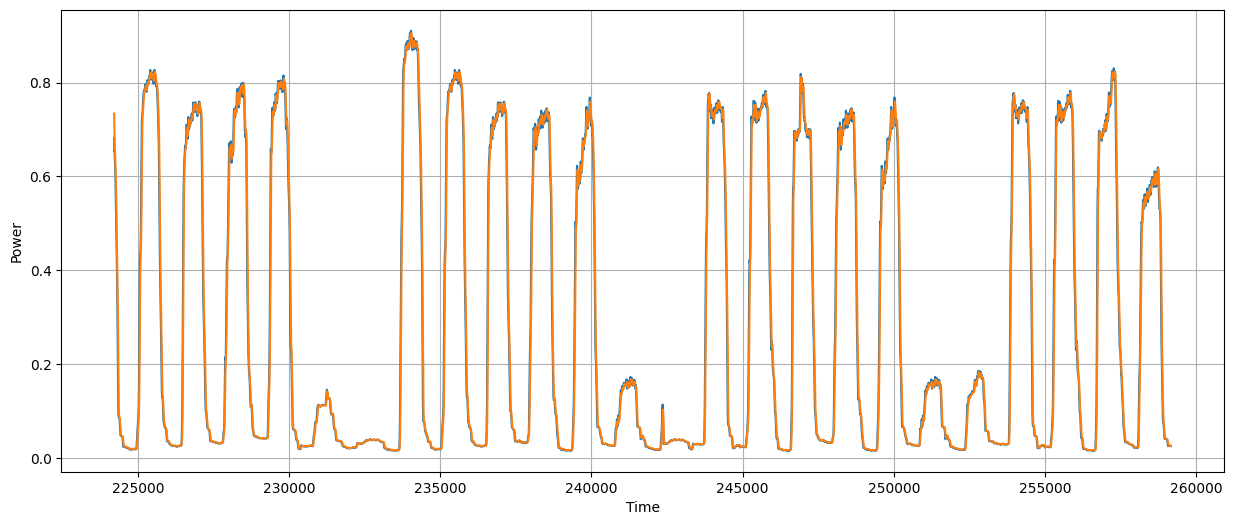

In [12]:
plt.figure(figsize=(15, 6))
plot_series(t_test, x_test)
plot_series(t_test, rnn_forecast_test)

In [13]:
tf.keras.metrics.mean_absolute_error(x_test, rnn_forecast_test).numpy()

array([0.46033043, 0.45771915, 0.4551931 , ..., 0.2622249 , 0.26223925,
       0.26225486], dtype=float32)

<Figure size 640x480 with 0 Axes>

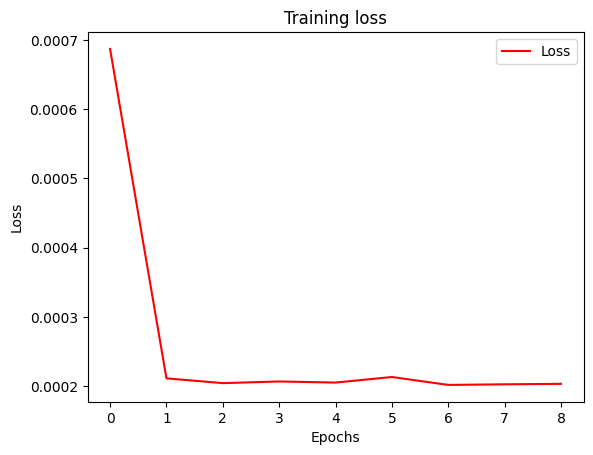

<Figure size 640x480 with 0 Axes>

In [14]:
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [29]:
rnn_forecast_test * 1128.28 + 38.25


array([[866.519  ],
       [862.362  ],
       [858.2364 ],
       ...,
       [ 68.15396],
       [ 68.12763],
       [ 68.09892]], dtype=float32)

In [30]:
x_test * 1128.28 + 38.25

array([807.28, 803.52, 799.86, ...,  66.96,  66.9 ,  66.9 ])

In [31]:
unnormal_max = 1128.28
unnormal_min = 38.25
original_forecast = rnn_forecast_test * unnormal_max + unnormal_min
original_test = x_test * unnormal_max + unnormal_min

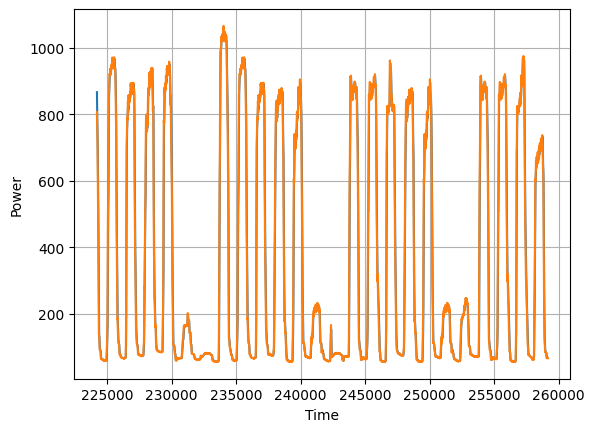

In [34]:
plot_series(t_test, original_forecast)
plot_series(t_test, original_test)

In [35]:
original_forecast

array([[866.519  ],
       [862.362  ],
       [858.2364 ],
       ...,
       [ 68.15396],
       [ 68.12763],
       [ 68.09892]], dtype=float32)

In [41]:
model_gru.save("model_gru_final.h5")
model_gru.save("model_gru_final", save_format="tf")

In [42]:
!zip -r /kaggle/working//model_gru_final.zip /kaggle/working//model_gru_final

  adding: kaggle/working//model_gru_final/ (stored 0%)
  adding: kaggle/working//model_gru_final/keras_metadata.pb (deflated 91%)
  adding: kaggle/working//model_gru_final/saved_model.pb (deflated 91%)
  adding: kaggle/working//model_gru_final/assets/ (stored 0%)
  adding: kaggle/working//model_gru_final/fingerprint.pb (stored 0%)
  adding: kaggle/working//model_gru_final/variables/ (stored 0%)
  adding: kaggle/working//model_gru_final/variables/variables.index (deflated 66%)
  adding: kaggle/working//model_gru_final/variables/variables.data-00000-of-00001 (deflated 7%)


In [44]:
model_gru.evaluate(x_test[..., np.newaxis])

1093/1093 [==============================] - 2s 2ms/step - loss: 0.0000e+00 - mae: 0.0000e+00


[0.0, 0.0]